## Part-of-Speech tagging using CRF

This project involves Parts Of Speech (POS) tagging using Conditional Random Fields (CRF) approach to achieve better accuracy than traditional HMM POS tagging techniques. The following steps are followed:

1. Data Preparation.
2. Define Feature Functions.
3. Train a CRF classifier with Grid Search  cross validation to find CRF model with best hyperparameters.
4. Checking accuracy of best CRF model on validation and test sets.
5. Find important state and transition features.

### Data Preparation

In [57]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import sklearn

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [2]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(wsj[:2])
print(len(wsj))

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]
3914


In [4]:
# reading the Brown tagged sentences
brown= list(nltk.corpus.brown.tagged_sents(tagset='universal'))

In [5]:
# first few tagged sentences
print(brown[:2])
print(len(brown))

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [6]:
# reading the conll2000 tagged sentences
conll2000= list(nltk.corpus.conll2000.tagged_sents(tagset='universal'))

In [7]:
# first few tagged sentences
print(conll2000[:2])
print(len(conll2000))

[[('Confidence', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('pound', 'NOUN'), ('is', 'VERB'), ('widely', 'ADV'), ('expected', 'VERB'), ('to', 'PRT'), ('take', 'VERB'), ('another', 'DET'), ('sharp', 'ADJ'), ('dive', 'NOUN'), ('if', 'ADP'), ('trade', 'NOUN'), ('figures', 'NOUN'), ('for', 'ADP'), ('September', 'NOUN'), (',', '.'), ('due', 'ADJ'), ('for', 'ADP'), ('release', 'NOUN'), ('tomorrow', 'NOUN'), (',', '.'), ('fail', 'VERB'), ('to', 'PRT'), ('show', 'VERB'), ('a', 'DET'), ('substantial', 'ADJ'), ('improvement', 'NOUN'), ('from', 'ADP'), ('July', 'NOUN'), ('and', 'CONJ'), ('August', 'NOUN'), ("'s", 'PRT'), ('near-record', 'ADJ'), ('deficits', 'NOUN'), ('.', '.')], [('Chancellor', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Exchequer', 'NOUN'), ('Nigel', 'NOUN'), ('Lawson', 'NOUN'), ("'s", 'PRT'), ('restated', 'VERB'), ('commitment', 'NOUN'), ('to', 'PRT'), ('a', 'DET'), ('firm', 'NOUN'), ('monetary', 'ADJ'), ('policy', 'NOUN'), ('has', 'VERB'), ('helped', 'VERB'), ('to', 'PRT'), ('prev

In [8]:
nltk_data = wsj + brown + conll2000

In [9]:
print(nltk_data[:2])
print(len(nltk_data))

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]
72202


In [10]:
nltk_data[1]

[('Mr.', 'NOUN'),
 ('Vinken', 'NOUN'),
 ('is', 'VERB'),
 ('chairman', 'NOUN'),
 ('of', 'ADP'),
 ('Elsevier', 'NOUN'),
 ('N.V.', 'NOUN'),
 (',', '.'),
 ('the', 'DET'),
 ('Dutch', 'NOUN'),
 ('publishing', 'VERB'),
 ('group', 'NOUN'),
 ('.', '.')]

In [58]:
# split data into training and validation and test set
train_set,test_set = train_test_split(nltk_data,train_size=0.85,test_size=0.15,random_state=101)
train_set,val_set = train_test_split(nltk_data,train_size=0.80,test_size=0.20,random_state=101)

### Define Features for feature function:

The following features are defined:
* word: the word itself.
* pos: POS tag of the word.
* prevword: previous word.
* prevpos: POS tag of previous word.
* prev2word: second previous word to the given word.
* prev2pos: POS tag of second previous word.
* nextword: next word.
* nextpos: POS tag of next word.
* pref_1, pref_2, pref_3, pref_4: 1,2,3 and 4 lenght prefix of the word.
* suff_1, suff_2, suff_3, suff_4: 1,2,3 and 4 lenght suffix of the word.

In [59]:
# extract features from a given sentence
def word_features(sent, i):
    word = sent[i][0]
    pos = sent[i][1]
    
    # first word
    if i==0:
        prevword = '<START>'
        prevpos = '<START>'
    else:
        prevword = sent[i-1][0]
        prevpos = sent[i-1][1]
        
    # first word
    if i==0 or i==1:
        prev2word = '<START>'
        prev2pos = '<START>'
    else:
        prev2word = sent[i-2][0]
        prev2pos = sent[i-2][1]
    
    # last word
    if i == len(sent)-1:
        nextword = '<END>'
        nextpos = '<END>'
    else:
        nextword = sent[i+1][0]
        nextpos = sent[i+1][1]
    
    # suffixes and prefixes
    pref_1, pref_2, pref_3, pref_4 = word[:1], word[:2], word[:3], word[:4]
    suff_1, suff_2, suff_3, suff_4 = word[-1:], word[-2:], word[-3:], word[-4:]
    
    rule_state = rule_based_tagger.tag([word])[0][1]
    
    return {'word':word,            
            'prevword': prevword,
            'prevpos': prevpos,  
            'nextword': nextword, 
            'nextpos': nextpos,          
            'suff_1': suff_1,  
            'suff_2': suff_2,  
            'suff_3': suff_3,  
            'suff_4': suff_4, 
            'pref_1': pref_1,  
            'pref_2': pref_2,  
            'pref_3': pref_3, 
            'pref_4': pref_4,
            'prev2word': prev2word,
            'prev2pos': prev2pos           
           }  

In [60]:
# let's check if our word feature is working correctly:
print(train_set[0][0:5])

word_features(train_set[0],3)

[('This', 'DET'), ('test', 'NOUN'), ('method', 'NOUN'), ('is', 'VERB'), ('intended', 'VERB')]


{'word': 'is',
 'prevword': 'method',
 'prevpos': 'NOUN',
 'nextword': 'intended',
 'nextpos': 'VERB',
 'suff_1': 's',
 'suff_2': 'is',
 'suff_3': 'is',
 'suff_4': 'is',
 'pref_1': 'i',
 'pref_2': 'is',
 'pref_3': 'is',
 'pref_4': 'is',
 'prev2word': 'test',
 'prev2pos': 'NOUN'}

In [61]:
# defining a few more functions to extract featrues, postags and words from sentences

def sent2features(sent):
    return [word_features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [postag for word, postag in sent]

def sent2tokens(sent):
    return [word for word, postag in sent]    

In [62]:
 # create training, validation and test sets
X_train = [sent2features(s) for s in train_set]
y_train = [sent2labels(s) for s in train_set]

X_valid = [sent2features(s) for s in val_set]
y_valid = [sent2labels(s) for s in val_set]

X_test = [sent2features(s) for s in test_set]
y_test = [sent2labels(s) for s in test_set]

In [85]:
# check the train set produced
print(X_train[0][0:10])

[{'word': 'This', 'prevword': '<START>', 'prevpos': '<START>', 'nextword': 'test', 'nextpos': 'NOUN', 'suff_1': 's', 'suff_2': 'is', 'suff_3': 'his', 'suff_4': 'This', 'pref_1': 'T', 'pref_2': 'Th', 'pref_3': 'Thi', 'pref_4': 'This', 'prev2word': '<START>', 'prev2pos': '<START>'}, {'word': 'test', 'prevword': 'This', 'prevpos': 'DET', 'nextword': 'method', 'nextpos': 'NOUN', 'suff_1': 't', 'suff_2': 'st', 'suff_3': 'est', 'suff_4': 'test', 'pref_1': 't', 'pref_2': 'te', 'pref_3': 'tes', 'pref_4': 'test', 'prev2word': '<START>', 'prev2pos': '<START>'}, {'word': 'method', 'prevword': 'test', 'prevpos': 'NOUN', 'nextword': 'is', 'nextpos': 'VERB', 'suff_1': 'd', 'suff_2': 'od', 'suff_3': 'hod', 'suff_4': 'thod', 'pref_1': 'm', 'pref_2': 'me', 'pref_3': 'met', 'pref_4': 'meth', 'prev2word': 'This', 'prev2pos': 'DET'}, {'word': 'is', 'prevword': 'method', 'prevpos': 'NOUN', 'nextword': 'intended', 'nextpos': 'VERB', 'suff_1': 's', 'suff_2': 'is', 'suff_3': 'is', 'suff_4': 'is', 'pref_1': 'i

In [86]:
y_train[0][0:10]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'DET', 'ADJ', 'NOUN']

### 1. Build CRF model

In [65]:
# fitting crf with arbitrary hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True   
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.01, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [67]:
labels = list(crf.classes_)

In [69]:
# make predictions 
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,
                      average='weighted', labels=labels)

0.9741010228208348

In [70]:
# class-wise scores
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          .      1.000     1.000     1.000     38304
          X      0.985     0.948     0.966      1508
        ADJ      0.938     0.930     0.934     21703
        ADP      0.969     0.979     0.974     36847
        ADV      0.949     0.934     0.941     13796
       VERB      0.981     0.977     0.979     46827
        DET      0.978     0.984     0.981     34166
       CONJ      0.995     0.996     0.995      9447
       NOUN      0.976     0.981     0.978     77111
       PRON      0.974     0.948     0.961     11946
        PRT      0.915     0.897     0.906      8240
        NUM      0.987     0.992     0.989      5537

avg / total      0.974     0.974     0.974    305432



We saw that good accuracy was achieved without any hyperparameter tuning, let's do grid search for optimal hyperparameters.

In [71]:
# hyperparameter tuning

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# parameters to tune
params_space = {
    'c1': [0.01, 0.1, 1],
    'c2': [0.01, 0.1, 1]
}

# use the same metric for evaluation
f1_scorer = scorers.make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [72]:
# instantiate a GridSearchCV object
rs = GridSearchCV(crf, 
                  params_space,
                  cv=3,
                  verbose=1,
                  n_jobs=3,
                  scoring=f1_scorer, 
                  return_train_score=True
                  )
# fit
rs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=3)]: Done  27 out of  27 | elapsed: 81.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(flat_f1_score, average=weighted, labels=['DET', 'NOUN', 'VERB', 'ADP', 'ADJ', 'CONJ', '.', 'PRT', 'ADV', 'NUM', 'PRON', 'X']),
       verbose=1)

In [73]:
# store CV results in a DF
cv_results = pd.DataFrame(rs.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_c1,param_c2,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,467.537247,5.081716,16.367672,0.967780,0.01,0.01,"{'c1': 0.01, 'c2': 0.01}",0.969676,0.970146,0.969554,0.969792,0.000255,8,0.996019,0.995943,0.995900,0.995954,0.000049
1,467.842181,9.940968,15.370219,1.712391,0.01,0.1,"{'c1': 0.01, 'c2': 0.1}",0.972447,0.972388,0.971897,0.972244,0.000247,2,0.993385,0.993322,0.993406,0.993371,0.000036
2,475.799096,7.578790,13.864925,0.084239,0.01,1,"{'c1': 0.01, 'c2': 1}",0.971253,0.971310,0.970707,0.971090,0.000272,6,0.980831,0.981007,0.981101,0.980980,0.000112
3,475.411781,4.384509,13.813850,0.337276,0.1,0.01,"{'c1': 0.1, 'c2': 0.01}",0.971444,0.971720,0.971195,0.971453,0.000215,3,0.995177,0.995150,0.995175,0.995167,0.000012
4,476.910408,4.320969,14.140330,0.230516,0.1,0.1,"{'c1': 0.1, 'c2': 0.1}",0.972584,0.972634,0.972072,0.972430,0.000254,1,0.992231,0.992224,0.992249,0.992235,0.000011
5,474.034696,4.043682,15.248725,1.806868,0.1,1,"{'c1': 0.1, 'c2': 1}",0.971015,0.971052,0.970509,0.970859,0.000248,7,0.979920,0.980069,0.980154,0.980048,0.000097
6,463.119183,5.116571,14.002142,0.542868,1,0.01,"{'c1': 1, 'c2': 0.01}",0.971535,0.971597,0.971148,0.971427,0.000199,4,0.978668,0.978594,0.978665,0.978642,0.000034
7,503.507508,7.961410,27.923450,11.615542,1,0.1,"{'c1': 1, 'c2': 0.1}",0.971316,0.971289,0.970874,0.971159,0.000202,5,0.977680,0.977541,0.977701,0.977640,0.000071
8,497.864503,7.563105,16.381788,3.276385,1,1,"{'c1': 1, 'c2': 1}",0.969250,0.969139,0.968881,0.969090,0.000154,9,0.973378,0.973311,0.973642,0.973444,0.000143


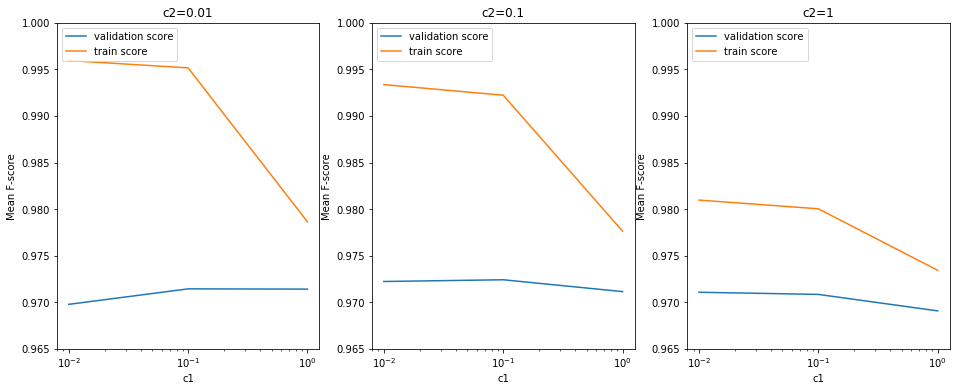

In [88]:
# plotting CV results
# for each value of c2, make a plot of c1 versus train and test f1-score

plt.figure(figsize=(16,6))

for i, val in enumerate(params_space['c2']):
   
    # subplot 1/3/i
    plt.subplot(1, 3, i+1)
    c2_subset = cv_results[cv_results['param_c2']==val]

    plt.plot(c2_subset["param_c1"], c2_subset["mean_test_score"])
    plt.plot(c2_subset["param_c1"], c2_subset["mean_train_score"])
    plt.xlabel('c1')
    plt.ylabel('Mean F-score')
    plt.title("c2={0}".format(val))
    plt.ylim([0.965, 1])
    plt.legend(['validation score', 'train score'], loc='upper left')
    plt.xscale('log')

The plot above shows that at very low values of c_1, the model overfits, as shown by the difference in training and test performance. Also, the test score seems to be slightly higher for c_2 = 0.1.

Let's thus choose c_1 = 0.1 and c_2 = 0.1. 

In [75]:
# building a model with optimal hyperparams
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [76]:
# save the model to a pickle file
import _pickle as cPickle

with open('tuned_crf_pos_tagger.pkl', 'wb') as clf:
    try:
        cPickle.dump(crf, clf)
    except Exception as e:
        print(e)
    finally:
        clf.close() 

### 2. Evaluate the model performance


In [77]:
# load the trained model
import _pickle as cPickle

with open('tuned_crf_pos_tagger.pkl', 'rb') as fid:
    crf = cPickle.load(fid)

In [78]:
# make predictions on validation data
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,
                      average='weighted', labels=labels)

0.9743218164217784

The overall f1-score is comparable to that on training (cross-validation) data (which was about 97% on the test folds and 99% on training folds). Let's look at class-wise metrics as well.

In [79]:
# class-wise scores on validation data
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          .      1.000     1.000     1.000     38304
          X      0.984     0.952     0.967      1508
        ADJ      0.936     0.930     0.933     21703
        ADP      0.969     0.979     0.974     36847
        ADV      0.950     0.935     0.942     13796
       VERB      0.981     0.978     0.979     46827
        DET      0.978     0.984     0.981     34166
       CONJ      0.994     0.996     0.995      9447
       NOUN      0.976     0.981     0.978     77111
       PRON      0.975     0.947     0.961     11946
        PRT      0.915     0.903     0.909      8240
        NUM      0.986     0.993     0.990      5537

avg / total      0.974     0.974     0.974    305432



#### evaluating model on test data

In [80]:
# test data predictions
# make predictions on validation data
y_pred_test = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred_test,
                      average='weighted', labels=labels)

0.974212618609641

We can see from above that test data accuracy is very close to validation set accuracy.

### 3. Interpret the model (enlist important state and transition features)

In [81]:
# import counter class from collections module
from collections import Counter

In [82]:
# important features
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(20))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-20:])

Top positive:
9.262594 ADJ      word:willing
8.598845 .        suff_1:$
7.914318 ADJ      word:interesting
7.616985 DET      word:some
7.371497 ADJ      word:lovely
7.324203 VERB     word:consists
7.305215 ADJ      suff_3:ous
7.268793 PRT      suff_2:'d
7.227447 NOUN     word:something
7.124260 VERB     prevword:may
7.021368 X        pref_1:*
6.992546 VERB     prevword:could
6.961264 ADJ      word:aware
6.695958 ADV      suff_4:wise
6.665385 VERB     prevword:didn't
6.589618 .        pref_1:.
6.474645 ADP      word:under
6.402197 NOUN     suff_1:%
6.383129 NOUN     word:year
6.360044 VERB     prevword:wouldn't

Top negative:
-3.856606 X        nextword:0
-3.956686 VERB     pref_4:self
-3.987874 VERB     suff_4:less
-4.001469 ADJ      pref_4:Unit
-4.029186 NOUN     pref_4:litt
-4.057932 ADP      nextword:Engine
-4.110473 NOUN     pref_2:it
-4.115595 VERB     suff_2:is
-4.150205 NOUN     pref_2:ei
-4.157736 X        nextword:*-1
-4.189975 VERB     suff_2:us
-4.193082 NOUN     word:least


We can see from above that some word feature combinations have very strong occurance:

* willing as Adjective (ADJ)
* suffix $ with '.'
* interesting as Adjective (ADJ)
* some as Determinant (DET)
* lovely ad Adjective (ADJ)

Similary, there are some word features combinations which are very unlikely:

* nextword '0' with for POS tag X
* pref_4: self for a Verb
* pref_4: unit for an Adjective (ADJ)
* pref_4: litt for a Noun

In [83]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
ADJ    -> NOUN    2.379253
NOUN   -> NOUN    2.024561
X      -> X       1.546455
VERB   -> NOUN    1.545528
DET    -> NOUN    1.451580
ADP    -> NOUN    1.417971
NUM    -> NOUN    1.361457
NOUN   -> .       1.242768
NOUN   -> VERB    1.219707
NOUN   -> PRON    1.104968
NOUN   -> PRT     1.089205
NOUN   -> ADV     1.079454
X      -> VERB    1.073886
PRT    -> VERB    1.073648
ADV    -> ADJ     0.992907
X      -> NOUN    0.985434
NOUN   -> ADP     0.933361
PRT    -> NOUN    0.881958
NOUN   -> NUM     0.847977
PRON   -> VERB    0.826426

Top unlikely transitions:
ADV    -> PRON    -0.671316
CONJ   -> PRON    -0.701904
ADP    -> .       -0.713027
PRON   -> PRON    -0.722607
PRON   -> ADP     -0.769217
NUM    -> DET     -0.810906
PRON   -> CONJ    -0.849257
DET    -> .       -0.849752
DET    -> PRT     -0.859365
X      -> NUM     -0.864570
DET    -> DET     -0.877747
PRT    -> CONJ    -0.930678
CONJ   -> X       -1.024626
NUM    -> PRON    -1.033381
DET    -> PRON   

We can see from above that some POS tag transitions are very likely:

* Adjective to Noun
* Noun to Noun
* No POS tag (X) to No POS tag (X)
* Verb to Noun

we can also see that some POS tag transitions are very unlikely:

* Adjective to Pronoun
* Conjunction to Pronoun
* Adposition to end of sentence
* Pronoun to Pronoun